In [ ]:
!wget https://www.dropbox.com/s/si11cws2pyho1bp/archive.zip

In [ ]:
!unzip -q "/content/archive.zip"

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

tf.random.set_seed(4)

In [ ]:
train_path = Path("/content/train")
test_path = Path("/content/test")

In [ ]:
#extracting image paths for train dataset
train_image_paths = list(train_path.glob("*/*"))
train_image_paths = list(map(lambda x : str(x) , train_image_paths))

In [ ]:
#extracting label(expression) for each image in train dataset
def extract_label(image_path):
    return image_path.split("/")[-2]
train_image_labels = list(map(lambda image : extract_label(image) , train_image_paths))

In [ ]:
from sklearn.preprocessing import LabelEncoder 

Le = LabelEncoder()
train_image_labels = Le.fit_transform(train_image_labels)

train_image_labels[:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
#switching label to vector input as multiclass labels are there
train_image_labels = tf.keras.utils.to_categorical(train_image_labels)

In [ ]:
from sklearn.model_selection import train_test_split 
Train_paths , Val_paths , Train_labels , Val_labels = train_test_split(train_image_paths , train_image_labels , test_size = 0.25)

In [ ]:
# Compute class weights 

classTotals = Train_labels.sum(axis=0)
classWeight = classTotals.max() / classTotals

class_weight = {e : weight for e , weight in enumerate(classWeight)}
print(class_weight)

{0: 1.861871, 1: 17.501587, 2: 1.7975221, 3: 1.0, 4: 1.4823878, 5: 1.523349, 6: 2.3590074}


In [ ]:
# Function used for Transformation

def load(image , label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    return image , label

In [ ]:
# Define IMAGE SIZE and BATCH SIZE 
IMG_SIZE = 96 
BATCH_SIZE = 32

# Basic Transformation
resize = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE)          
])

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor = (-0.1, -0.05))
])

In [ ]:
# Function used to Create a Tensorflow Data Object
AUTOTUNE = tf.data.experimental.AUTOTUNE
def get_dataset(paths , labels , train = True):
    image_paths = tf.convert_to_tensor(paths)
    labels = tf.convert_to_tensor(labels)

    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    label_dataset = tf.data.Dataset.from_tensor_slices(labels)

    dataset = tf.data.Dataset.zip((image_dataset , label_dataset))

    dataset = dataset.map(lambda image , label : load(image , label))
    dataset = dataset.map(lambda image, label: (resize(image), label) , num_parallel_calls=AUTOTUNE)
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(BATCH_SIZE)

    if train:
        dataset = dataset.map(lambda image, label: (data_augmentation(image), label) , num_parallel_calls=AUTOTUNE)
    
    dataset = dataset.repeat()
    return dataset

In [ ]:
# Creating Train Dataset object and Verifying it
%time train_dataset = get_dataset(Train_paths , Train_labels)

image , label = next(iter(train_dataset))
print(image.shape)
print(label.shape)

CPU times: user 303 ms, sys: 1.89 ms, total: 305 ms
Wall time: 305 ms
(32, 96, 96, 3)
(32, 7)


5


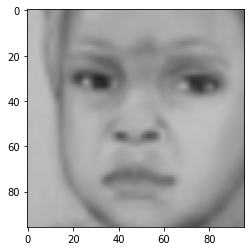

In [ ]:
# View a sample Training Image
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(96 , 96 , 3))

In [ ]:
%time val_dataset = get_dataset(Val_paths , Val_labels , train = False)

image , label = next(iter(val_dataset))
print(image.shape)
print(label.shape)

CPU times: user 52.6 ms, sys: 0 ns, total: 52.6 ms
Wall time: 52.1 ms
(32, 96, 96, 3)
(32, 7)


3


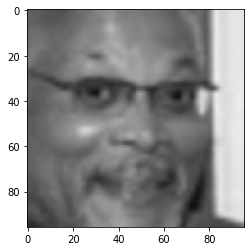

In [ ]:
# View a sample Validation Image
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(96 , 96 , 3))

In [ ]:
# Building EfficientNet model
from tensorflow.keras.applications import EfficientNetB2

backbone = EfficientNetB2(
    input_shape=(96, 96, 3),
    include_top=False
)

model = tf.keras.Sequential([
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])

model.summary()

31801344/31790344 [==============================] - 1s 0us/step
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional)  (None, 3, 3, 1408)       7768569   
                                                                 
 global_average_pooling2d (G  (None, 1408)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1408)              0         
                                                                 
 dense (Dense)               (None, 128)               180352    
                                                                 
 dense_1 (Dense)             (None, 7)                 903       
                                                                 
Total params: 7,949,824
Trainable params: 7,882,249
Non

In [ ]:
# Compiling your model by providing the Optimizer , Loss and Metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = 'categorical_crossentropy',
    metrics=['accuracy' , tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
)

In [ ]:
# Train the model
history = model.fit(
    train_dataset,
    steps_per_epoch=len(Train_paths)//BATCH_SIZE,
    epochs=12,
    validation_data=val_dataset,
    validation_steps = len(Val_paths)//BATCH_SIZE,
    class_weight=class_weight
)

Epoch 1/12
672/672 [==============================] - 119s 140ms/step - loss: 2.8950 - accuracy: 0.3882 - precision: 0.6482 - recall: 0.1784 - val_loss: 1.4040 - val_accuracy: 0.4701 - val_precision: 0.6460 - val_recall: 0.3047
Epoch 2/12
672/672 [==============================] - 93s 136ms/step - loss: 2.5297 - accuracy: 0.4697 - precision: 0.6783 - recall: 0.2583 - val_loss: 1.3020 - val_accuracy: 0.5261 - val_precision: 0.6757 - val_recall: 0.3694
Epoch 3/12
672/672 [==============================] - 92s 137ms/step - loss: 2.3053 - accuracy: 0.5201 - precision: 0.7025 - recall: 0.3233 - val_loss: 1.2583 - val_accuracy: 0.5321 - val_precision: 0.7063 - val_recall: 0.3499
Epoch 4/12
672/672 [==============================] - 91s 136ms/step - loss: 2.2108 - accuracy: 0.5346 - precision: 0.7105 - recall: 0.3458 - val_loss: 1.2502 - val_accuracy: 0.5511 - val_precision: 0.6611 - val_recall: 0.4460
Epoch 5/12
672/672 [==============================] - 91s 136ms/step - loss: 2.0985 - accur

In [ ]:
model.layers[0].trainable = False

In [ ]:
# Defining our callbacks 
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_weights.h5",verbose=1,save_best_only=True,save_weights_only = True)
early_stop = tf.keras.callbacks.EarlyStopping(patience=4)

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional)  (None, 3, 3, 1408)       7768569   
                                                                 
 global_average_pooling2d (G  (None, 1408)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1408)              0         
                                                                 
 dense (Dense)               (None, 128)               180352    
                                                                 
 dense_1 (Dense)             (None, 7)                 903       
                                                                 
Total params: 7,949,824
Trainable params: 181,255
Non-trainable params: 7,768,569
______________________________________

In [ ]:
# Train the model
history = model.fit(
    train_dataset,
    steps_per_epoch=len(Train_paths)//BATCH_SIZE,
    epochs=8,
    callbacks=[checkpoint , early_stop],
    validation_data=val_dataset,
    validation_steps = len(Val_paths)//BATCH_SIZE,
    class_weight=class_weight
)

Epoch 1/8
672/672 [==============================] - ETA: 0s - loss: 1.6839 - accuracy: 0.6270 - precision: 0.7509 - recall: 0.4931
Epoch 1: val_loss improved from inf to 1.07435, saving model to best_weights.h5
672/672 [==============================] - 91s 135ms/step - loss: 1.6839 - accuracy: 0.6270 - precision: 0.7509 - recall: 0.4931 - val_loss: 1.0743 - val_accuracy: 0.5965 - val_precision: 0.7045 - val_recall: 0.4792
Epoch 2/8
672/672 [==============================] - ETA: 0s - loss: 1.6584 - accuracy: 0.6387 - precision: 0.7540 - recall: 0.5002
Epoch 2: val_loss did not improve from 1.07435
672/672 [==============================] - 90s 134ms/step - loss: 1.6584 - accuracy: 0.6387 - precision: 0.7540 - recall: 0.5002 - val_loss: 1.0947 - val_accuracy: 0.5992 - val_precision: 0.7085 - val_recall: 0.4873
Epoch 3/8
672/672 [==============================] - ETA: 0s - loss: 1.6109 - accuracy: 0.6459 - precision: 0.7590 - recall: 0.5203
Epoch 3: val_loss did not improve from 1.0743

Testing Phase

In [ ]:
from tensorflow.keras.applications import EfficientNetB2

backbone = EfficientNetB2(
    input_shape=(96, 96, 3),
    include_top=False
)

model = tf.keras.Sequential([
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = 'categorical_crossentropy',
    metrics=['accuracy' , tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
)

In [ ]:
model.load_weights("best_weights.h5")

In [ ]:
# Create a Dataset Object for 'Testing' Set just the way we did for Training and Validation
test_image_paths = list(test_path.glob("*/*"))
test_image_paths = list(map(lambda x : str(x) , test_image_paths))
test_labels = list(map(lambda x : get_label(x) , test_image_paths))

test_labels = Le.transform(test_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

test_image_paths = tf.convert_to_tensor(test_image_paths)
test_labels = tf.convert_to_tensor(test_labels)

def decode_image(image , label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    image = tf.image.resize(image , [96 , 96] , method="bilinear")
    return image , label

test_dataset = (
     tf.data.Dataset
    .from_tensor_slices((test_image_paths, test_labels))
    .map(decode_image)
    .batch(BATCH_SIZE)
)

In [ ]:
# Verify Test Dataset Object
image , label = next(iter(test_dataset))
print(image.shape)
print(label.shape)

(32, 96, 96, 3)
(32, 7)


disgust


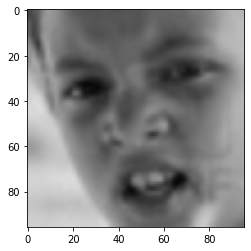

In [ ]:
# View a sample Validation Image
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(96 , 96 , 3))

In [ ]:
# Evaluating the loaded model
loss, acc, prec, rec = model.evaluate(test_dataset)

print(" Testing Acc : " , acc)
print(" Testing Precision " , prec)
print(" Testing Recall " , rec)

225/225 [==============================] - 9s 26ms/step - loss: 1.1528 - accuracy: 0.5663 - precision: 0.6564 - recall: 0.4516
 Testing Acc :  0.622596800327301
 Testing Precision  0.7180851101875305
 Testing Recall  0.5266090631484985


Save Objects

In [ ]:
# Save Model
model.save("FacialExpressionModel.h5")

In [ ]:
# Save Label Encoder 
import pickle

def save_object(obj , name):
    pickle_obj = open(f"{name}.pck","wb")
    pickle.dump(obj, pickle_obj)
    pickle_obj.close()

In [ ]:
save_object(Le, "LabelEncoder")